Block 1 



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Code block 2 Model

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


Code block 3


In [15]:
# Train data transformations
train_transforms = transforms.Compose([
   transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
   transforms.Resize((28, 28)),
   transforms.RandomRotation((-15., 15.), fill=0),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,)),
   ])

In [26]:
# Test data transformations
test_transforms = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
   ])

In [17]:
import os
os.environ["https_proxy"] = "http://185.46.212.90:80"
os.environ["http_proxy"] = "http://185.46.212.90:80"

Code Block 4 Utils

In [19]:
train_data = datasets.MNIST('../data', train=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False,  transform=test_transforms)

Code block 5

In [20]:
batch_size = 512
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

Code block 6 

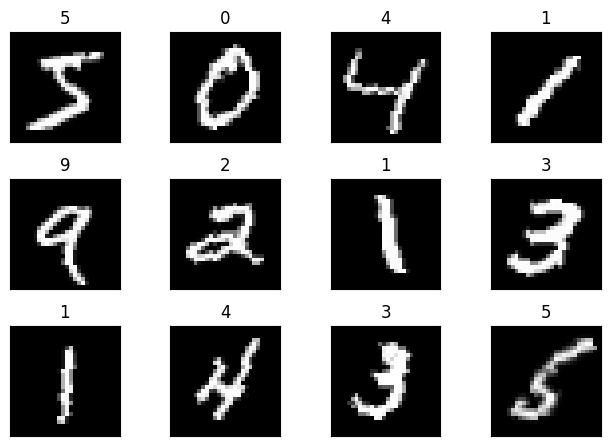

In [8]:
import matplotlib.pyplot as plt
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
for i in range(12):
 plt.subplot(3,4,i+1)
 plt.tight_layout()
 plt.imshow(batch_data[i].squeeze(0), cmap='gray')
 plt.title(batch_label[i].item())
 plt.xticks([])
 plt.yticks([])


Code block 7

In [21]:
class Net(nn.Module):
   #This defines the structure of the NN.
   def __init__(self):
       super(Net, self).__init__()
       self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias=False)
       self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias=False)
       self.conv3 = nn.Conv2d(64, 128, kernel_size=3, bias=False)
       self.conv4 = nn.Conv2d(128, 256, kernel_size=3, bias=False)
       self.fc1 = nn.Linear(4096, 50, bias=False)
       self.fc2 = nn.Linear(50, 10, bias=False)
   def forward(self, x):
       x = F.relu(self.conv1(x), 2)
       x = F.relu(F.max_pool2d(self.conv2(x), 2))
       x = F.relu(self.conv3(x), 2)
       x = F.relu(F.max_pool2d(self.conv4(x), 2))
       x = x.view(-1, 4096)
       x = F.relu(self.fc1(x))
       x = self.fc2(x)
       return F.log_softmax(x, dim=1)

Code block 8

In [22]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

Code Block 9

In [23]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

Code block 10

In [25]:
device="cuda"
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20
for epoch in range(1, num_epochs+1):
 print(f'Epoch {epoch}')
 train(model, device, train_loader, optimizer, criterion)
 test(model, device, train_loader, criterion)
 scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2553 Batch_id=117 Accuracy=59.90: 100%|██████████| 118/118 [00:06<00:00, 17.28it/s]


Test set: Average loss: 0.2859, Accuracy: 54879/60000 (91.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1232 Batch_id=117 Accuracy=94.39: 100%|██████████| 118/118 [00:06<00:00, 17.43it/s]


Test set: Average loss: 0.1482, Accuracy: 57253/60000 (95.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1057 Batch_id=117 Accuracy=96.19: 100%|██████████| 118/118 [00:06<00:00, 17.46it/s]


Test set: Average loss: 0.1035, Accuracy: 58057/60000 (96.76%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1179 Batch_id=117 Accuracy=96.95: 100%|██████████| 118/118 [00:06<00:00, 17.43it/s]


Test set: Average loss: 0.0832, Accuracy: 58465/60000 (97.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0852 Batch_id=117 Accuracy=97.65: 100%|██████████| 118/118 [00:06<00:00, 17.63it/s]


Test set: Average loss: 0.0649, Accuracy: 58796/60000 (97.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1401 Batch_id=117 Accuracy=97.78: 100%|██████████| 118/118 [00:06<00:00, 17.61it/s]


Test set: Average loss: 0.0722, Accuracy: 58681/60000 (97.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0569 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:06<00:00, 17.60it/s]


Test set: Average loss: 0.0532, Accuracy: 59030/60000 (98.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0332 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:06<00:00, 17.62it/s]


Test set: Average loss: 0.0684, Accuracy: 58739/60000 (97.90%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1336 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:06<00:00, 17.65it/s]


Test set: Average loss: 0.0454, Accuracy: 59166/60000 (98.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0522 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:06<00:00, 17.63it/s]


Test set: Average loss: 0.0419, Accuracy: 59202/60000 (98.67%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0948 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:06<00:00, 17.62it/s]


Test set: Average loss: 0.0472, Accuracy: 59089/60000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0434 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:06<00:00, 17.46it/s]


Test set: Average loss: 0.0383, Accuracy: 59286/60000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0697 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:06<00:00, 17.55it/s]


Test set: Average loss: 0.0333, Accuracy: 59390/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0841 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:06<00:00, 17.76it/s]


Test set: Average loss: 0.0316, Accuracy: 59387/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0715 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:06<00:00, 17.50it/s]


Test set: Average loss: 0.0318, Accuracy: 59420/60000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0420 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:06<00:00, 17.85it/s]


Test set: Average loss: 0.0265, Accuracy: 59538/60000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0156 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:06<00:00, 17.61it/s]


Test set: Average loss: 0.0254, Accuracy: 59520/60000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0040 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:06<00:00, 17.34it/s]


Test set: Average loss: 0.0265, Accuracy: 59500/60000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0100 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:06<00:00, 17.61it/s]


Test set: Average loss: 0.0258, Accuracy: 59525/60000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0341 Batch_id=117 Accuracy=99.27: 100%|██████████| 118/118 [00:06<00:00, 17.64it/s]


Test set: Average loss: 0.0247, Accuracy: 59526/60000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.


Code Block 11

Text(0.5, 1.0, 'Test Accuracy')

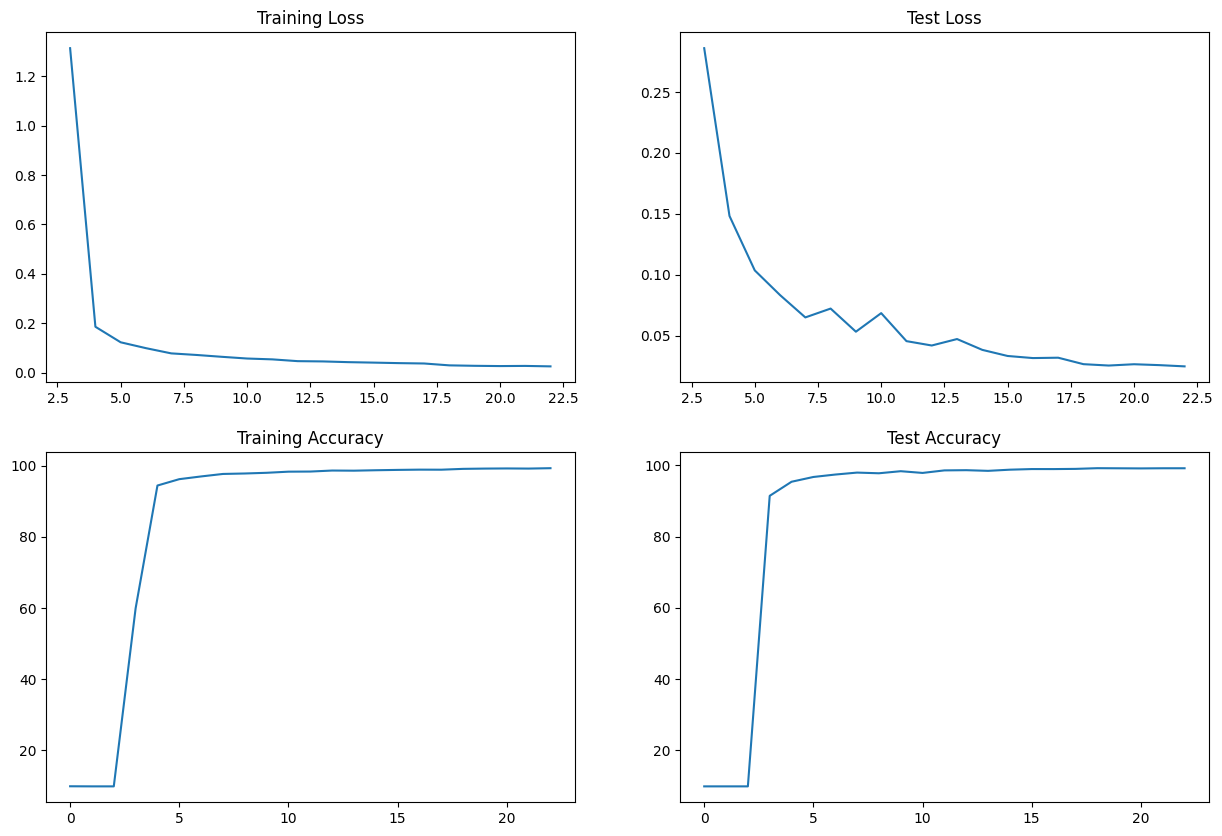

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")